# Introduction

### Problem Description

It will be written soon.

### Software Requirements

(tensorflow)

# General Preparations

### Import Statements

In [15]:
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import r2_score

### Data Extraction and Exploratory Analysis

In [2]:
ser = pd.read_csv('series_with_plateaus.csv', sep='\t')
ser.head()

,value
0,337.0
1,337.0
2,341.0
3,341.5
4,344.0


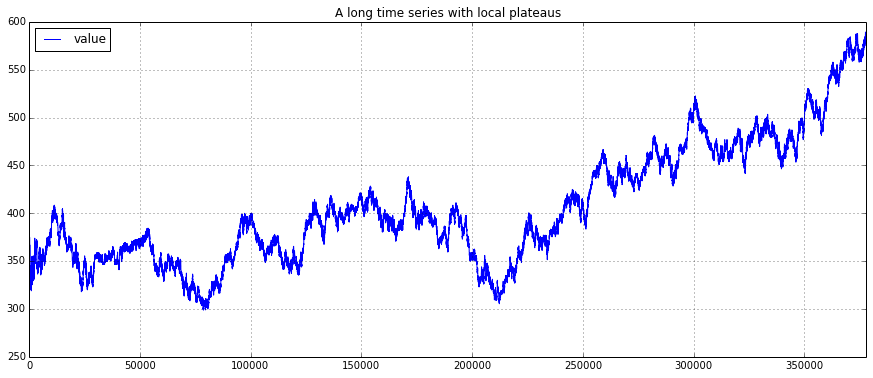

In [5]:
_ = ser.plot(figsize=(15, 6), grid=True,
             title='A long time series with local plateaus')

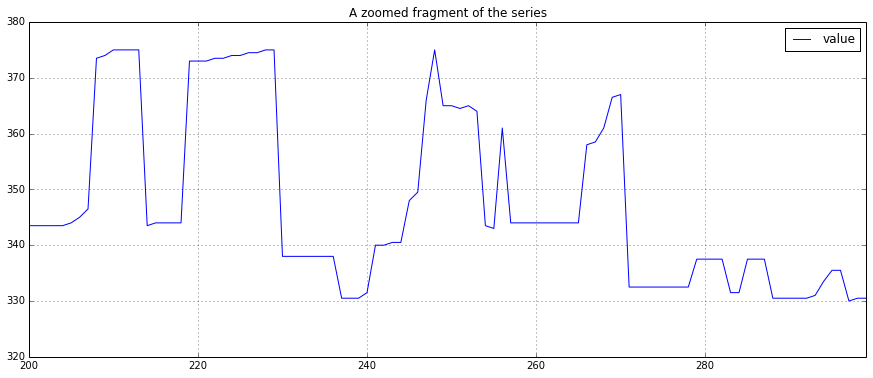

In [12]:
_ = ser[200:300].plot(figsize=(15, 6), grid=True, ylim=[320, 380],
                      title='A zoomed fragment of the series')

What forecast quality can be achieved by a simple baseline model such as, say, MA(3)?

In [19]:
ma_preds = ser.shift().rolling(window=3, min_periods=1).mean()
ma_preds.iloc[0] = 0
ma_preds.head()

,value
0,0.000000
1,337.000000
2,337.000000
3,338.333333
4,339.833333


In [23]:
r2_score(ser, ma_preds)

0.99980922101699699

Above score means that almost all variation of the series around its mean can be explained by MA(3). However, this is caused by slow changes in values rather than by outstanding performance of MA(3). Local variations around local means are not explained perfectly. Let us look at some examples.

In [26]:
r2_score(ser[-100:], ma_preds[-100:])

0.74662316000926254

In [28]:
r2_score(ser[-1100:-1000], ma_preds[-1100:-1000])

0.81838331324090685

Another important thing that should be noticed here, is that the above scores relate to multiple one-step-ahead forecasts. If there is a need to create a forecast with long horizon, MA(3) is not a good choice. To see this, split data to a "train" set (actually, MA(3) has no fitting) and a hold-out test set. 

In [ ]:
# TODO: MA(3) forecast with horizon.

# Forecasting with bare LSTM